In [1]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

In [5]:
from Simulation import *

env, observations_probabilities = generate_new_environment()

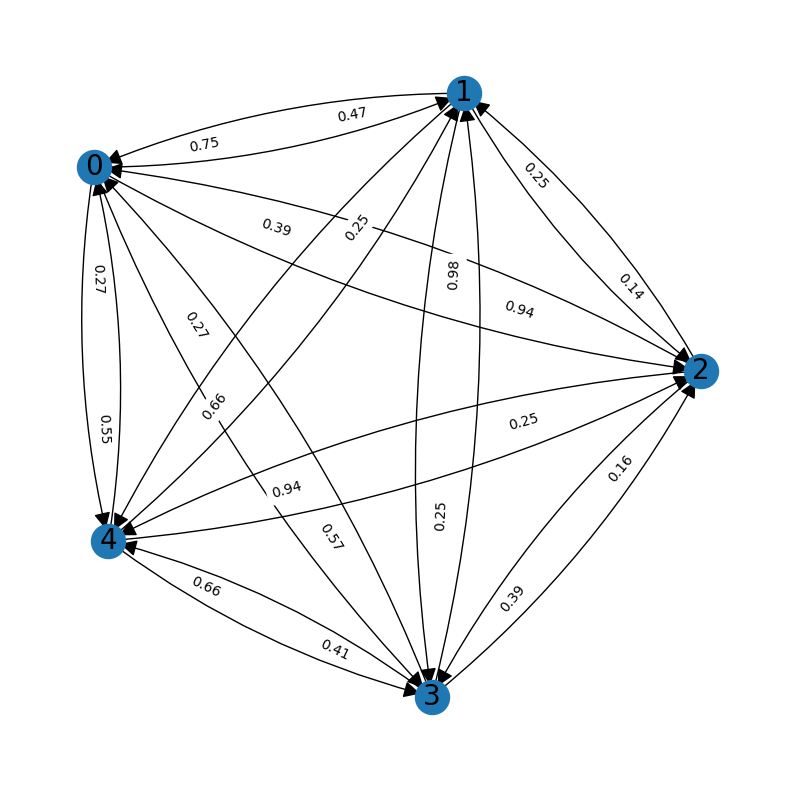

In [8]:
from Network import *
Network.print_graph(env.get_network().G)

In [9]:
ecommerce = Ecommerce(B_cap, budgets, product_prices, observations_probabilities)

In [20]:
exp_clicks = ecommerce.estimate_expected_num_clicks(env)
optimal_allocation = ecommerce.solve_optimization_problem(
    env.get_network().get_adjacency_matrix(), env.get_num_items_sold(), env.get_users_reservation_prices(), exp_clicks)


optimal solution found is: [40. 80. 40. 40.  0.]
